# Resources used

In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

#from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, GridSearchCV

import sklearn
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [2]:
print(f"shap: v.{shap.__version__}")
print(f"numpy: v.{np.__version__}")
print(f"pandas: v.{pd.__version__}")
print(f"seaborn: v.{sns.__version__}")
print(f"matplotlib: v.{matplotlib.__version__}")
print(f"sklearn: v.{sklearn.__version__}")
print(f"XGBoost: v.{xgb.__version__}")

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 12

shap: v.0.47.0
numpy: v.1.25.2
pandas: v.2.2.3
seaborn: v.0.13.2
matplotlib: v.3.6.2
sklearn: v.1.4.2
XGBoost: v.2.1.2


# Exploratory data analisys

## Data collection

In [3]:
df = pd.read_csv('数据时间导出.csv')  # 47 features
df = df.rename(columns={'VD0000':'impl_spd2',  # Main fan speed [rps]
                        'VD0008':'pump_spd',  # Peristaltic pump rotation speed [rps]
                        'VD0012':'I',  # Current [A]
                        'VD0016':'V',  # Voltage [V]
                        'VD0020':'W',  # Power [Wt]
                        'VD0028':'Q_CH4',  # CH4 flow rate [m3/h]
                        'VD0032':'impl_spd1',  # Cooling fan speed [rps]
                        'VD0036':'Q_CH4_N2',  #CH4/N2 flow rate [m3/h]
                        'VD0040':'P_NG',  # Differential natural gas pressure [bar]
                        'VD44':'O2',  # Inlet air oxygen concentration [%]
                        'VD208':'T3',  # bottom of the burner temperature [°C]
                        'VD212':'T4',  # top of the burner temperature [°C]
                        'VD216':'T5',  # inlet of the reformer temperature [°C]
                        'VD224':'T7',  # exhaust gases from the SOFC temperature [°C]
                        'VD232':'T9',  # heat exchanger temperature [°C]
                        'VD244':'T12',  # water temperature for steam reforming [°C]
                        'VD260':'T16',  # left front point of the SOFC temperature [°C]
                        'VD264':'T17',  # right rear point of the SOFC temperature [°C]
                        'VD272':'T19',  # air at the inlet of the SOFC temperature [°C]
                        'VD276':'T20',  # hydrogen at the inlet of the SOFC temperature [°C]
                        'VD280':'T21',  # air at the outlet of the SOFC temperature [°C]
                        'VD284':'T22',  # hydrogen at the outlet of the SOFC temperature [°C]
                        'VD288':'T23',  # top rear point of the reformer temperature [°C]
                        'VD292':'T24',  # bottom rear point of the reformer temperature [°C]
                        'VD296':'T25',  # top left point of the reformer temperature [°C]
                        'VD300':'T26',  # bottom left point of the reformer temperature [°C]
                        'VD304':'T27',  # top right point of the reformer temperature [°C]
                        'VD308':'T28',  # bottom right point of the reformer temperature [°C]
                        'VD316':'T30',  # cooling water temperature [°C]
                        'VD320':'T31'})  # water tank temperature [°C]

df.MCGS_TIME = pd.to_datetime(df.MCGS_TIME)
df = df.set_index('MCGS_TIME')
df = df.drop(columns=['MCGS_TIMEMS', 'VD48', 'VD0004', 'VD0024'])  # drop 4 useless features
df = df[df.columns[(abs(df.mean()-3000)>0.1)]]  # filtering 12 incorrect sensor readings
df = df[df.T17 != 3000]  # remove 92 lines with incorrect T17-value

# combine similar features (-4)
df.T3 = df[['T3', 'T4']].mean(axis=1)
df.T23 = df[['T23', 'T24']].mean(axis=1)
df.T25 = df[['T25', 'T26']].mean(axis=1)
df.T27 = df[['T27', 'T28']].mean(axis=1)
df = df.drop(columns=['T4', 'T24', 'T26', 'T28'])

# move the voltage to the end position (for correlation matrix)
V = df.V
df = df.drop('V', axis=1)
df['V'] = V

#df.to_excel(f'DATA.xlsx')

print(df.info())
df.iloc[5480:5490, :]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32751 entries, 2024-04-23 14:47:36 to 2025-02-18 22:01:05
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   impl_spd2  32751 non-null  float64
 1   I          32751 non-null  float64
 2   pump_spd   32751 non-null  float64
 3   W          32751 non-null  float64
 4   Q_CH4      32751 non-null  float64
 5   impl_spd1  32751 non-null  float64
 6   Q_CH4_N2   32751 non-null  float64
 7   P_NG       32751 non-null  float64
 8   T3         32751 non-null  float64
 9   T5         32751 non-null  float64
 10  T7         32751 non-null  float64
 11  T9         32751 non-null  float64
 12  T12        32751 non-null  float64
 13  T16        32751 non-null  float64
 14  T17        32751 non-null  float64
 15  T19        32751 non-null  float64
 16  T20        32751 non-null  float64
 17  T21        32751 non-null  float64
 18  T22        32751 non-null  float64
 19  T23        

,impl_spd2,I,pump_spd,W,Q_CH4,impl_spd1,Q_CH4_N2,P_NG,T3,T5,...,T20,T21,T22,T23,T25,T27,T30,T31,O2,V
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2024-04-25 12:37:27,15.0,0.03,30.0,1.257,0.000099,9.0,8.738488,0.011885,871.600006,677.700012,...,736.299988,710.900024,650.700012,623.100006,703.350006,775.400024,80.400002,65.099998,13.2500,41.900002
2024-04-25 12:37:57,15.0,0.03,30.0,1.260,0.000099,9.0,8.748823,0.011911,875.000000,677.700012,...,736.400024,710.900024,650.700012,622.899994,703.200012,775.199982,80.400002,65.199997,13.3125,42.000000
2024-04-25 12:38:27,15.0,0.03,30.0,1.257,0.000099,9.0,8.679254,0.011913,872.549988,677.700012,...,736.299988,710.900024,650.599976,623.000000,703.149994,775.100006,80.400002,65.199997,13.2500,41.900002
2024-04-25 12:38:57,15.0,0.03,30.0,1.266,0.000099,9.0,9.393169,0.011970,873.300018,677.599976,...,736.200012,710.900024,650.599976,622.850006,703.250000,774.949982,80.300003,65.199997,13.3125,42.200001
2024-04-25 12:39:27,15.0,0.03,30.0,1.260,0.000099,9.0,8.748520,0.011914,875.000000,677.599976,...,736.200012,710.900024,650.599976,622.850006,702.850006,774.899994,80.300003,65.199997,13.2500,42.000000
2024-04-25 12:39:57,15.0,0.03,30.0,1.257,0.000099,9.0,8.835536,0.011905,872.100006,677.500000,...,736.000000,710.900024,650.599976,622.849976,703.100006,774.899994,80.199997,65.199997,13.3125,41.900002
2024-04-25 12:40:27,15.0,0.03,30.0,1.263,0.000099,9.0,9.045634,0.011936,875.250000,677.500000,...,736.000000,710.799988,650.599976,622.800018,703.050018,774.850006,80.099998,65.199997,13.3125,42.099998
2024-04-25 12:40:57,15.0,0.03,30.0,1.260,0.000099,9.0,8.897305,0.011921,873.799988,677.400024,...,736.000000,710.900024,650.599976,622.850006,702.899994,774.850006,79.900002,65.199997,13.2500,42.000000
2024-04-25 12:41:27,15.0,0.03,30.0,1.257,0.000099,9.0,8.682378,0.011871,871.600006,677.400024,...,736.000000,710.799988,650.599976,622.899994,703.149994,774.850006,79.699997,65.099998,13.2500,41.900002


## Correlation matrix of initial features

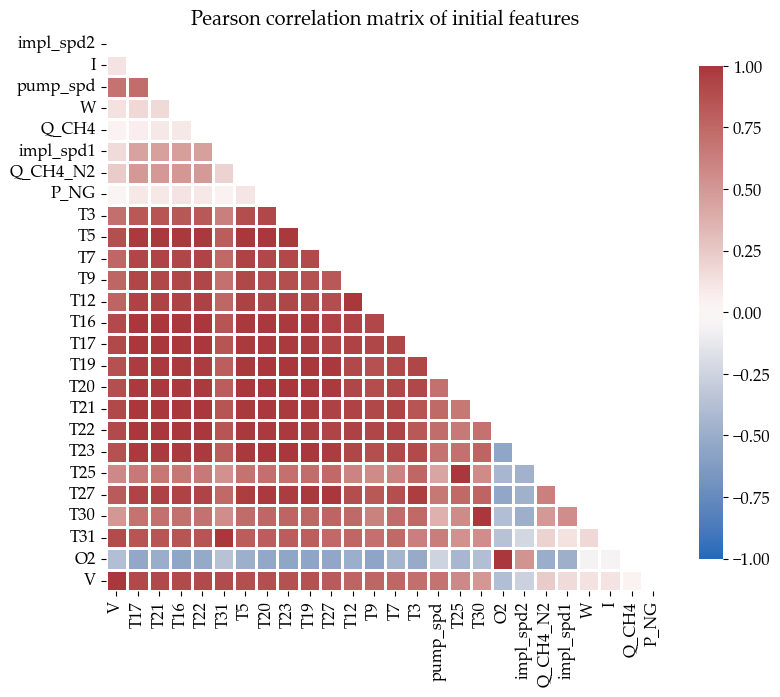

In [4]:
df_corr = df.corr('pearson')

# Let's sort column B by correlation strength (absolute value)
df_corr.sort_values(by='V', axis='columns', ascending=False, inplace=True, key=lambda col: abs(col))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(9, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, 
            #annot=True, 
            mask=mask, 
            cmap=sns.color_palette("vlag", as_cmap=True), 
            fmt=".3f", 
            vmax=1.0, 
            vmin=-1.0, 
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .8}).set(title='Pearson correlation matrix of initial features')

plt.savefig('pictures/full_corr_matrix.png', dpi = 300, transparent = True)
# df_corr.style.background_gradient(cmap=color_map, vmin = -1, vmax=1)  # output table-factor

## Data preprocessing

In [5]:
X = df.drop(columns='V').copy()  # input feature
y = df.V.copy()  # target feature (Voltage [V])

# Standardization of input feature general set 
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

# Spliting data into train and test sets
X_train, X_test, y_train, y_test= train_test_split(X_std, y, test_size=0.2, random_state=42)

## Feature important

In [6]:
objective='reg:absoluteerror'
n = 10  # desired count of components

перерисовать графики feature importance (Box plot)

### XGBoost features importance (MDI)

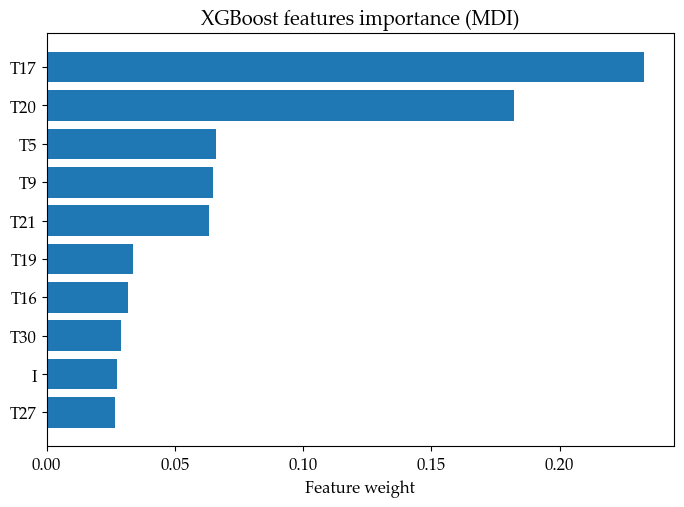

,importance
T27,0.026512
I,0.027539
T30,0.029061
T16,0.031735
T19,0.033742
T21,0.063430
T9,0.064816
T5,0.066103
T20,0.182060
T17,0.232931


In [7]:
selector = xgb.XGBRegressor(objective=objective, eval_metric='mape', random_state=42)
selector.fit(X_std, y)

feature_importances = pd.DataFrame({'importance' : selector.feature_importances_}, 
                                   index=X_std.columns).sort_values(by='importance', ascending=True)

feature_importances = feature_importances.iloc[-n:, :]  # get n-strongest features

plt.figure(figsize=(7, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.tight_layout()
plt.savefig('pictures/standard_feature_important.png', dpi = 300, transparent = True)
plt.title('XGBoost features importance (MDI)')
plt.show()

feature_importances

### Permutation Importance (PI)

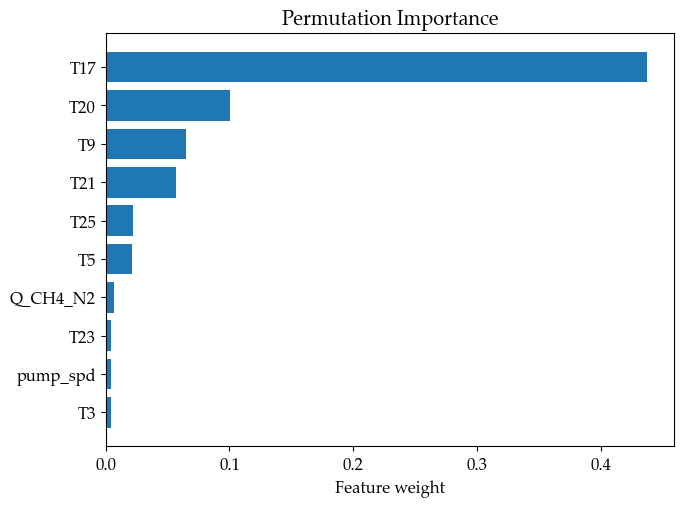

,importance
T3,0.003926
pump_spd,0.003927
T23,0.004626
Q_CH4_N2,0.006867
T5,0.021119
T25,0.021736
T21,0.056404
T9,0.064641
T20,0.100107
T17,0.437368


In [8]:
feature_importances = pd.DataFrame(
    {'importance' : permutation_importance(selector, X_std, y, n_repeats=5, random_state=42, n_jobs=-1).importances_mean},
    index=X_std.columns).sort_values(by='importance', ascending=True)

feature_importances = feature_importances.iloc[-n:, :]  # get 10 strongest features

plt.figure(figsize=(7, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.tight_layout()
plt.savefig('pictures/Permutation_Importance.png', dpi = 300, transparent = True)
plt.title('Permutation Importance')
plt.show()

feature_importances

### SHapley Additive exPlanations (SHAP)

<function matplotlib.pyplot.show(close=None, block=None)>

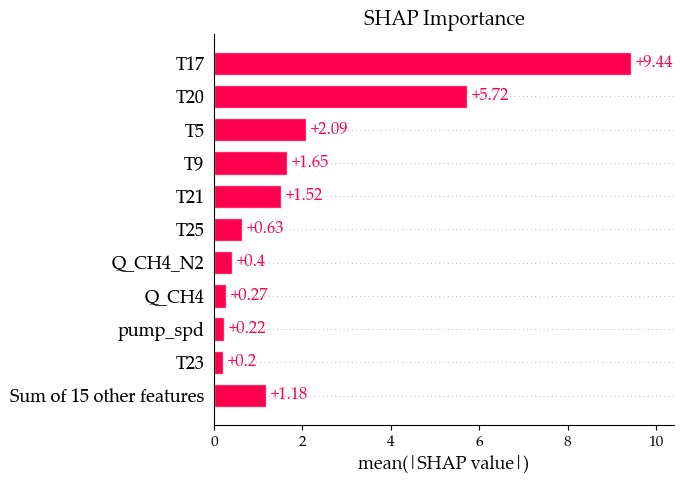

In [9]:
explainer = shap.Explainer(selector)
shap_importances = explainer(X_std)

shap.plots.bar(shap_importances, max_display=n+1, show=False)

plt.gcf().set_size_inches(7, n/2)
plt.title('SHAP Importance')
plt.tight_layout()
plt.savefig('pictures/SHAP_Importance.png', dpi = 300, transparent = True)
plt.show

###	Principal component analysis (PCA)

In [18]:
# Features PCA decomposition
n = 7  # number strongest features
pca = PCA(n_components=n)
pca.fit(X_std)
X_dec = pca.fit_transform(X_std)
X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

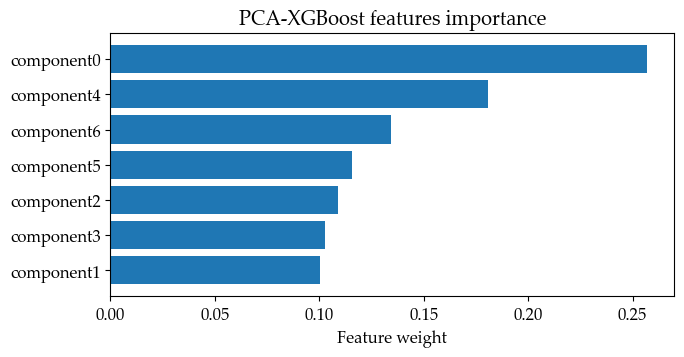

,importance
component1,0.100537
component3,0.102736
component2,0.108900
component5,0.115728
component6,0.134216
component4,0.180864
component0,0.257019


In [19]:
selector = xgb.XGBRegressor(objective=objective, eval_metric='mape', random_state=42)
selector.fit(X_dec, y)

feature_importances = pd.DataFrame({'importance' : selector.feature_importances_}, 
                                   index=X_dec.columns).sort_values(by='importance', ascending=True)

plt.figure(figsize=(7, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.tight_layout()
plt.savefig('pictures/PCA-Decomposed_feature_important.png', dpi = 300, transparent = True)
plt.title('PCA-XGBoost features importance')
plt.show()

feature_importances

###  Search learning objective

**(!)squarederror**  *the most narrative features* <br> 
<br>top 3 high weights
- MDI:  0.965586, 0.009850, 0.007659
- PI:   0.593551, 0.058517, 0.054146
- SHAP: 15.56, 1.53, 1.33
- PCA:  0.892817, 0.031799, 0.029172

<br>top 10 strong feature
- MDI:  T21, T17, T5, T20, T16, T25, T9, T22, Q_CH_N2, pump_spd
- PI:   Т21, T17, T5, T20, T16, T3, T9, I, T19, W
- SHAP: Т21, Т17, Т5, Т20, Т16, Т3, Т9, I, Q_CH_N2, W  

general signs for PI and SHAP (9): **Т21, Т17, Т5, Т20, Т16, Т3, Т9, I, W** <br>

**squaredlogerror**
- MDI:  0.674076, 0.283172, 0.011238
- PI:   0.314902, 0.140141, 0.098361
- SHAP: 8.11, 5.51, 1.32
- PCA:  0.771667, 0.070112, 0.065652
+
- MDI:   T21, T17, T20, T16, T9, T30, Q_CH4, impl_spd1, impl_spd2, O2
- PI:    T21, T17, T20, T16, T9, T22, Q_CH4_N2, T25, T27, pump_spd
- SHAP:  T21, T17, T20, T16, T9, T22, Q_CH4_N2, T5, impl_spd1, pump_spd
 <br>
general signs for PI and SHAP (8): **T21, T17, T20, T16, T9, T22, Q_CH4_N2, pump_spd** <br>

<br>**pseudohubererror** 
- MDI:  0.228194, 0.126173, 0.095932
- PI:   3994.005569, 1944.821739, 1343.692211
- SHAP: –
- PCA:  0.410946, 0.251196, 0.156792
+
- MDI:  T20, T5, T21, T17, T19, T16, T23, T3, Q_CH4_N2, T27
- PI:   T20, T5, T21, T17, T19, T16, T23, T3, Q_CH4_N2, T27
- SHAP: –
 <br>
general signs for PI and MDI 10/10, *but SHAP breaks* <br>

<br>**(!)absoluteerror**  *the best distribution of weights between features* <br>
- **MDI:  0.232931, 0.182060, 0.066103**
- **PI:   0.437368, 0.100107, 0.064641**
- **SHAP: 9.44, 5.72, 2.09**
- **PCA:  0.257019, 0.180864, 0.134216**
+ 
- MDI:  T17, T20, T5, T9, T21, T19, T16, T30, I, T27
- PI:   T17, T20, T5, T9, T21, T25, Q_CH4_N2, pump_spd, T3, T23
- SHAP: T17, T20, T5, T9, T21, T25, Q_CH4_N2, Q_CH4, pump_spd, T23

general signs for PI and SHAP (9): **T17, T20, T5, T9, T21, T25, Q_CH4_N2, pump_spd, T23**  <br>
 <br>
**Total:**
- General strong features: T21, T17, T20, Q_CH4_N2 <br>
- General average features: T16, T5, T9, pump_spd <br>